# Spiking Neural Network (SNN) for Branch Prediction

This notebook implements a Spiking Neural Network to predict CPU branch behavior (Taken/Not Taken).

## Network Architecture:
- **Input Layer**: 64 neurons (32 PC bits + 32 Branch History bits)
- **Hidden Layer**: 16 Leaky Integrate-and-Fire (LIF) neurons
- **Output Layer**: 2 neurons (Taken / Not Taken)

## Approach:
- Each input bit is treated as a spike (1 = spike present, 0 = no spike)
- Using snnTorch library for SNN implementation
- Binary classification based on output neuron spike activity

## 1. Setup Development Environment
Install required libraries and configure the development environment.

In [47]:
!pip install snntorch torch pandas numpy scikit-learn matplotlib tqdm

In [48]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
# Check if GPU 1 exists, otherwise fall back to standard logic
if torch.cuda.device_count() > 1:
    device = torch.device("cuda:1")
else:
    print("⚠️ GPU 1 not found. Falling back to default.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
print("✓ Libraries imported successfully!")

In [49]:
import sys
from datetime import datetime
import os
from IPython.display import display

class TeeLogger:
    """Logger that writes to both notebook output and file simultaneously"""
    def __init__(self, filename):
        # Store the original stdout (Jupyter's display system)
        self.terminal = sys.__stdout__
        self.log = open(filename, 'w', encoding='utf-8')
        
    def write(self, message):
        # Write to notebook output
        self.terminal.write(message)
        self.terminal.flush()
        # Write to log file
        self.log.write(message)
        self.log.flush()
        
    def flush(self):
        self.terminal.flush()
        self.log.flush()
        
    def close(self):
        self.log.close()
        sys.stdout = self.terminal

# Create outputs folder if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Generate timestamp for unique log file
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = f'outputs/snn_full_model_{timestamp}.log'

# Redirect stdout to TeeLogger
tee = TeeLogger(log_file)
sys.stdout = tee

print("="*70)
print(f"SNN Training Session Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Log file: {log_file}")
print("="*70 + "\n")

## 2. Load and Prepare Dataset

In [50]:
# Load the processed branch prediction dataset
data_file = 'data/branch_data_processed.csv'

print(f"Loading dataset: {data_file}")
df = pd.read_csv(data_file)

print(f"\n✓ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"\nFirst few rows:")
display(df.head())

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,BH_23,BH_24,BH_25,BH_26,BH_27,BH_28,BH_29,BH_30,BH_31,Taken
0,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [51]:
# Separate features and target
# Features: First 64 columns (32 PC bits + 32 Branch History bits)
# Target: Last column (Taken)

X = df.iloc[:, :64].values  # 64 input features
y = df.iloc[:, -1].values   # Target (0 or 1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(f"  Not Taken (0): {np.sum(y == 0):,} ({np.mean(y == 0)*100:.2f}%)")
print(f"  Taken (1): {np.sum(y == 1):,} ({np.mean(y == 1)*100:.2f}%)")

In [52]:
# Split into train and test sets SEQUENTIALLY (no shuffling)
# This preserves temporal order - crucial for branch prediction patterns!
split_idx = int(0.8 * len(X))
X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

print(f"✓ Sequential split (maintains execution order)")
print(f"Training set size: {len(X_train):,} (first 80%)")
print(f"Test set size: {len(X_test):,} (last 20%)")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

print(f"  y_train: {y_train_tensor.shape}")

print(f"\nTensor shapes:")
print(f"  X_train: {X_train_tensor.shape}")

In [53]:
# Create DataLoaders for batch processing
# shuffle=False to maintain sequential order!
batch_size = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

## 3. Define Spiking Neural Network Architecture

Build the SNN model with LIF neurons using foundational classes and functions.

In [54]:
# Define number of timesteps for spike simulation
num_steps = 25  # Number of timesteps to simulate

class SpikingNeuralNetwork(nn.Module):
    """
    Spiking Neural Network for Branch Prediction
    
    Architecture:
    - Input: 64 neurons (binary spikes)
    - Hidden: 16 LIF neurons
    - Output: 2 LIF neurons (Taken / Not Taken)
    """
    def __init__(self, input_size=64, hidden_size=16, output_size=2, beta=0.95, num_steps=25):
        super(SpikingNeuralNetwork, self).__init__()
        
        self.num_steps = num_steps
        
        # Surrogate gradient for backpropagation through spikes
        spike_grad = surrogate.fast_sigmoid(slope=25)
        
        # Layer 1: Input -> Hidden
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Layer 2: Hidden -> Output
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
    def forward(self, x):
        """
        Forward pass through the SNN.
        
        Args:
            x: Input tensor (batch_size, 64)
        
        Returns:
            spk_rec: Output spike recordings
            mem_rec: Output membrane potential recordings
        """
        # Initialize hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Recording lists
        spk2_rec = []
        mem2_rec = []
        
        # Simulate over timesteps
        for step in range(self.num_steps):
            # Input spikes (binary input treated as spikes)
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        # Stack recordings
        spk2_rec = torch.stack(spk2_rec, dim=0)
        mem2_rec = torch.stack(mem2_rec, dim=0)
        
        return spk2_rec, mem2_rec


# Instantiate the model
model = SpikingNeuralNetwork(
    input_size=64,
    hidden_size=16,
    output_size=2,
    beta=0.95,
    num_steps=num_steps
).to(device)

print("Spiking Neural Network Architecture:")
print("="*50)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

## 4. Implement Core Training Logic

Define loss function, optimizer, and training/evaluation functions.

In [55]:
# Loss function: Cross Entropy using spike count
# The neuron with more spikes indicates the predicted class
loss_fn = SF.ce_count_loss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("Loss function: Cross Entropy Count Loss (based on spike counts)")
print("Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print("Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

In [56]:
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        
        # Forward pass
        spk_rec, mem_rec = model(data)
        
        # Calculate loss
        loss = loss_fn(spk_rec, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy based on spike count
        # Sum spikes across timesteps and get predicted class
        spike_count = spk_rec.sum(dim=0)  # (batch_size, 2)
        predicted = spike_count.argmax(dim=1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, test_loader, loss_fn, device):
    """Evaluate the model on test data."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            
            # Forward pass
            spk_rec, mem_rec = model(data)
            
            # Calculate loss
            loss = loss_fn(spk_rec, targets)
            total_loss += loss.item()
            
            # Calculate accuracy based on spike count
            spike_count = spk_rec.sum(dim=0)
            predicted = spike_count.argmax(dim=1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, all_predictions, all_targets

print("✓ Training and evaluation functions defined!")

## 5. Train the Model with Error Handling

Execute training loop with proper error handling and validation.

In [57]:
# Training parameters
num_epochs = 5

# Lists to store training history
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("="*70)
print(" "*20 + "TRAINING SPIKING NEURAL NETWORK")
print("="*70)
print(f"\nEpochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Timesteps: {num_steps}")
print("\n" + "-"*70)

try:
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        
        # Evaluate
        test_loss, test_acc, _, _ = evaluate(model, test_loader, loss_fn, device)
        
        # Update scheduler
        scheduler.step(test_loss)
        
        # Store history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print progress
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    print("-"*70)
    print(f"\n✓ Training complete!")
    print(f"Best Test Accuracy: {max(test_accuracies):.2f}%")

except Exception as e:
    print(f"\n❌ Error during training: {e}")
    import traceback
    traceback.print_exc()

## 6. Test the Implementation

Verify inference accuracy and visualize results.

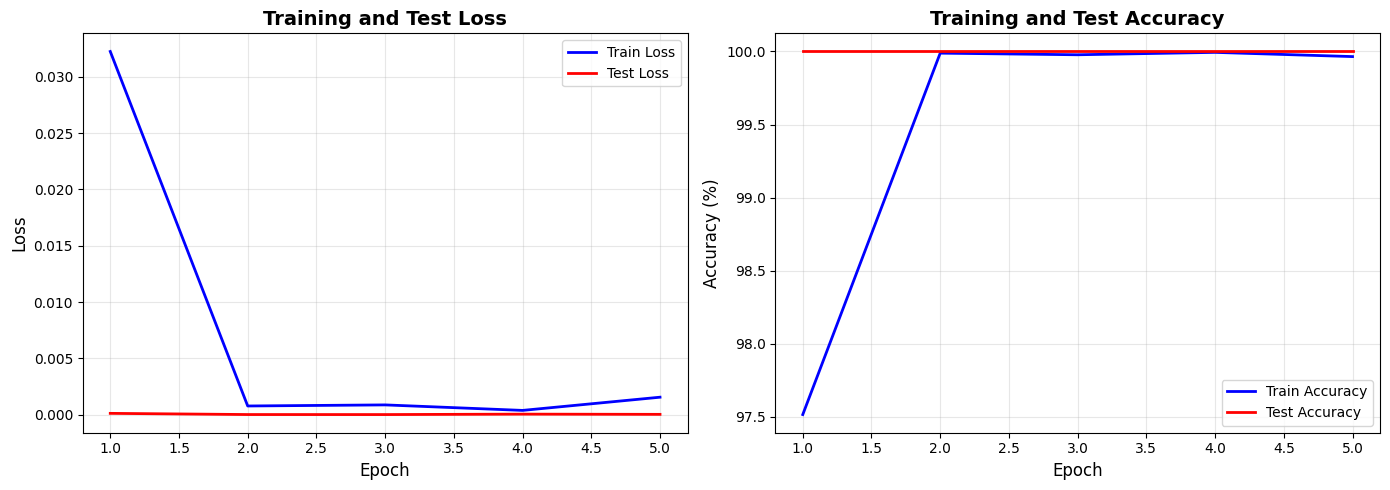

In [58]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0].plot(range(1, num_epochs+1), test_losses, 'r-', label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(range(1, num_epochs+1), train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
axes[1].plot(range(1, num_epochs+1), test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/snn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history saved to 'results/snn_training_history.png'")

In [59]:
# Final evaluation on test set
print("Running final inference on test set...\n")

test_loss, test_acc, predictions, targets = evaluate(model, test_loader, loss_fn, device)

print("="*70)
print(" "*20 + "INFERENCE RESULTS")
print("="*70)

print(f"\n🎯 Test Accuracy: {test_acc:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

# Classification report
print(f"\n📊 Classification Report:")
print("-"*50)
print(classification_report(targets, predictions, target_names=['Not Taken', 'Taken']))

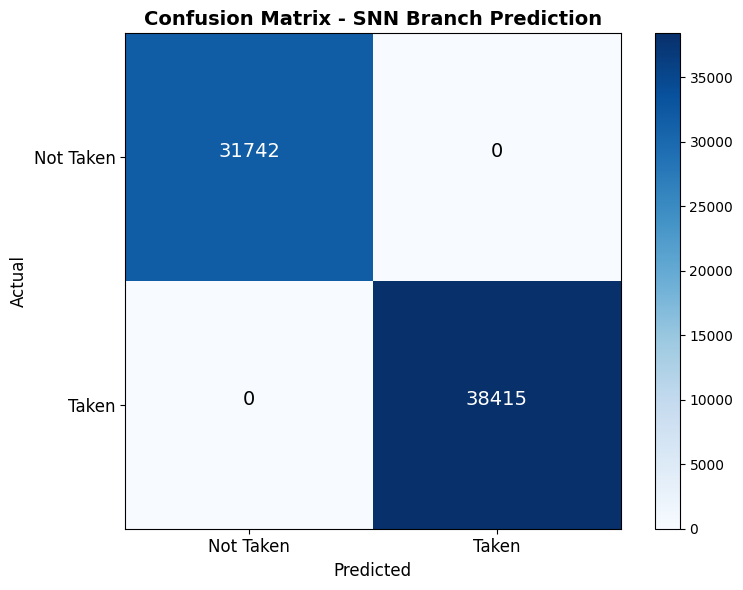

In [60]:
# Confusion Matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - SNN Branch Prediction', fontsize=14, fontweight='bold')
plt.colorbar()

classes = ['Not Taken', 'Taken']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                fontsize=14,
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('snn_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to 'snn_confusion_matrix.png'")

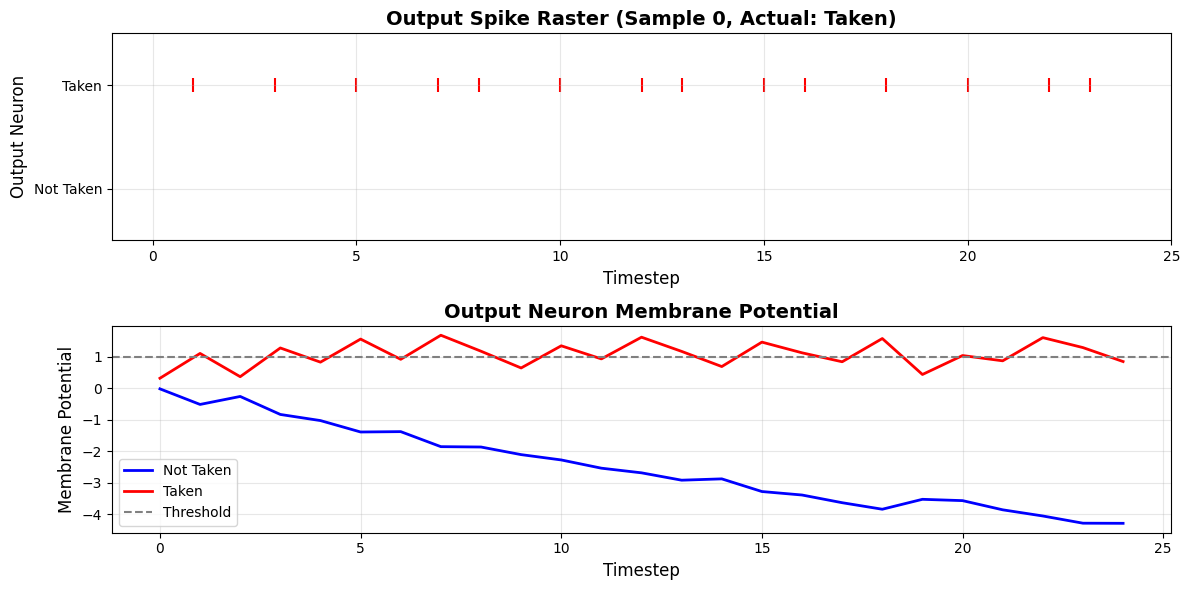

In [61]:
# Visualize spike activity for a sample input
model.eval()

# Get a sample batch
sample_data, sample_targets = next(iter(test_loader))
sample_data = sample_data.to(device)

with torch.no_grad():
    spk_rec, mem_rec = model(sample_data)

# Plot spike raster for first sample
sample_idx = 0
spk_sample = spk_rec[:, sample_idx, :].cpu().numpy()  # (timesteps, 2)

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Spike raster plot
for neuron in range(2):
    spike_times = np.where(spk_sample[:, neuron] > 0)[0]
    axes[0].scatter(spike_times, [neuron] * len(spike_times), marker='|', s=100, 
                   color='blue' if neuron == 0 else 'red')

axes[0].set_xlim(-1, num_steps)
axes[0].set_ylim(-0.5, 1.5)
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['Not Taken', 'Taken'])
axes[0].set_xlabel('Timestep', fontsize=12)
axes[0].set_ylabel('Output Neuron', fontsize=12)
axes[0].set_title(f'Output Spike Raster (Sample {sample_idx}, Actual: {"Taken" if sample_targets[sample_idx]==1 else "Not Taken"})', 
                 fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Membrane potential plot
mem_sample = mem_rec[:, sample_idx, :].cpu().numpy()
axes[1].plot(range(num_steps), mem_sample[:, 0], 'b-', label='Not Taken', linewidth=2)
axes[1].plot(range(num_steps), mem_sample[:, 1], 'r-', label='Taken', linewidth=2)
axes[1].axhline(y=1.0, color='gray', linestyle='--', label='Threshold')
axes[1].set_xlabel('Timestep', fontsize=12)
axes[1].set_ylabel('Membrane Potential', fontsize=12)
axes[1].set_title('Output Neuron Membrane Potential', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/snn_spike_activity.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Spike activity visualization saved to 'results/snn_spike_activity.png'")

## Summary

In [62]:
print("="*70)
print(" "*15 + "SPIKING NEURAL NETWORK - SUMMARY")
print("="*70)

print(f"\n📊 Network Architecture:")
print(f"   Input Layer: 64 neurons (32 PC + 32 Branch History bits)")
print(f"   Hidden Layer: 16 LIF neurons")
print(f"   Output Layer: 2 LIF neurons (Taken / Not Taken)")
print(f"   Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\n⚙️ Training Configuration:")
print(f"   Epochs: {num_epochs}")
print(f"   Batch Size: {batch_size}")
print(f"   Timesteps: {num_steps}")
print(f"   Learning Rate: 0.001")
print(f"   Beta (membrane decay): 0.95")

print(f"\n📈 Dataset:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")

print(f"\n🎯 Final Results:")
print(f"   Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"   Test Accuracy: {test_acc:.2f}%")
print(f"   Best Test Accuracy: {max(test_accuracies):.2f}%")

print(f"\n💾 Saved Files:")
print(f"   Model: models/snn_branch_predictor.pth")
print(f"   Training History: results/snn_training_history.png")
print(f"   Confusion Matrix: results/snn_confusion_matrix.png")
print(f"   Spike Activity: results/snn_spike_activity.png")

print("\n" + "="*70)
print("✓ Implementation complete! SNN model trained successfully.")
print("="*70)

## 7. Feature Ablation Study - PC Only Model

Train an SNN using only Program Counter (PC) bits to evaluate their individual contribution to prediction accuracy.

In [63]:
# Close previous log and start new log for PC-only model
sys.stdout.close()
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_file_pc = f'outputs/snn_pc_only_{timestamp}.log'
tee_pc = TeeLogger(log_file_pc)
sys.stdout = tee_pc

print("\n" + "="*70)
print(f"SNN PC-Only Model Training Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Log file: {log_file_pc}")
print("="*70 + "\n")

In [64]:
# Prepare PC-only dataset (first 32 columns)
X_train_pc = X_train[:, :32]  # PC bits only
X_test_pc = X_test[:, :32]

print("PC-Only Dataset:")
print(f"  Training shape: {X_train_pc.shape}")
print(f"  Test shape: {X_test_pc.shape}")

# Convert to tensors
X_train_pc_tensor = torch.FloatTensor(X_train_pc)
X_test_pc_tensor = torch.FloatTensor(X_test_pc)

# Create DataLoaders
train_dataset_pc = TensorDataset(X_train_pc_tensor, y_train_tensor)
test_dataset_pc = TensorDataset(X_test_pc_tensor, y_test_tensor)

train_loader_pc = DataLoader(train_dataset_pc, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader_pc = DataLoader(test_dataset_pc, batch_size=batch_size, shuffle=False, drop_last=False)

print(f"  Training batches: {len(train_loader_pc)}")
print(f"  Test batches: {len(test_loader_pc)}")

In [65]:
# Create PC-only SNN model (32 inputs)
model_pc = SpikingNeuralNetwork(
    input_size=32,  # Only PC bits
    hidden_size=16,
    output_size=2,
    beta=0.95,
    num_steps=num_steps
).to(device)

print("\n📊 PC-Only SNN Architecture:")
print("="*50)
print(f"   Input: 32 neurons (PC bits only)")
print(f"   Hidden: 16 LIF neurons")
print(f"   Output: 2 LIF neurons")
print(f"   Parameters: {sum(p.numel() for p in model_pc.parameters()):,}")

# Setup optimizer and scheduler for PC model
optimizer_pc = torch.optim.Adam(model_pc.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_pc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_pc, mode='min', factor=0.5, patience=3)

In [66]:
# Train PC-only model
train_losses_pc = []
train_accuracies_pc = []
test_losses_pc = []
test_accuracies_pc = []

print("\n" + "="*70)
print(" "*18 + "TRAINING PC-ONLY SNN MODEL")
print("="*70)
print(f"Input features: PC bits only (32 neurons)")
print("-"*70)

try:
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model_pc, train_loader_pc, optimizer_pc, loss_fn, device)
        test_loss, test_acc, _, _ = evaluate(model_pc, test_loader_pc, loss_fn, device)
        scheduler_pc.step(test_loss)
        
        train_losses_pc.append(train_loss)
        train_accuracies_pc.append(train_acc)
        test_losses_pc.append(test_loss)
        test_accuracies_pc.append(test_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    print("-"*70)
    print(f"✓ PC-Only Model Training Complete!")
    print(f"   Best Test Accuracy: {max(test_accuracies_pc):.2f}%")
    print(f"   Final Test Accuracy: {test_accuracies_pc[-1]:.2f}%")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

## 8. Feature Ablation Study - Branch History Only Model

Train an SNN using only Branch History bits to evaluate their individual contribution to prediction accuracy.

In [67]:
# Close previous log and start new log for Branch History-only model
sys.stdout.close()
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_file_bh = f'outputs/snn_bh_only_{timestamp}.log'
tee_bh = TeeLogger(log_file_bh)
sys.stdout = tee_bh

print("\n" + "="*70)
print(f"SNN Branch History-Only Model Training Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Log file: {log_file_bh}")
print("="*70 + "\n")

In [68]:
# Prepare Branch History-only dataset (columns 32-63)
X_train_bh = X_train[:, 32:64]  # Branch History bits only
X_test_bh = X_test[:, 32:64]

print("Branch History-Only Dataset:")
print(f"  Training shape: {X_train_bh.shape}")
print(f"  Test shape: {X_test_bh.shape}")

# Convert to tensors
X_train_bh_tensor = torch.FloatTensor(X_train_bh)
X_test_bh_tensor = torch.FloatTensor(X_test_bh)

# Create DataLoaders
train_dataset_bh = TensorDataset(X_train_bh_tensor, y_train_tensor)
test_dataset_bh = TensorDataset(X_test_bh_tensor, y_test_tensor)

train_loader_bh = DataLoader(train_dataset_bh, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader_bh = DataLoader(test_dataset_bh, batch_size=batch_size, shuffle=False, drop_last=False)

print(f"  Training batches: {len(train_loader_bh)}")
print(f"  Test batches: {len(test_loader_bh)}")

In [69]:
# Create Branch History-only SNN model (32 inputs)
model_bh = SpikingNeuralNetwork(
    input_size=32,  # Only Branch History bits
    hidden_size=16,
    output_size=2,
    beta=0.95,
    num_steps=num_steps
).to(device)

print("\n📊 Branch History-Only SNN Architecture:")
print("="*50)
print(f"   Input: 32 neurons (Branch History bits only)")
print(f"   Hidden: 16 LIF neurons")
print(f"   Output: 2 LIF neurons")
print(f"   Parameters: {sum(p.numel() for p in model_bh.parameters()):,}")

# Setup optimizer and scheduler for BH model
optimizer_bh = torch.optim.Adam(model_bh.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_bh = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_bh, mode='min', factor=0.5, patience=3)

In [70]:
# Train Branch History-only model
train_losses_bh = []
train_accuracies_bh = []
test_losses_bh = []
test_accuracies_bh = []

print("\n" + "="*70)
print(" "*13 + "TRAINING BRANCH HISTORY-ONLY SNN MODEL")
print("="*70)
print(f"Input features: Branch History bits only (32 neurons)")
print("-"*70)

try:
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model_bh, train_loader_bh, optimizer_bh, loss_fn, device)
        test_loss, test_acc, _, _ = evaluate(model_bh, test_loader_bh, loss_fn, device)
        scheduler_bh.step(test_loss)
        
        train_losses_bh.append(train_loss)
        train_accuracies_bh.append(train_acc)
        test_losses_bh.append(test_loss)
        test_accuracies_bh.append(test_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    print("-"*70)
    print(f"✓ Branch History-Only Model Training Complete!")
    print(f"   Best Test Accuracy: {max(test_accuracies_bh):.2f}%")
    print(f"   Final Test Accuracy: {test_accuracies_bh[-1]:.2f}%")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

## 9. Compare All Three Models

Compare the performance of Full model (PC + BH), PC-only model, and Branch History-only model.

In [71]:
# Final evaluation for all models
print("\n" + "="*70)
print(" "*15 + "FEATURE ABLATION STUDY - RESULTS")
print("="*70)

# Get final test accuracies
_, acc_full, _, _ = evaluate(model, test_loader, loss_fn, device)
_, acc_pc, _, _ = evaluate(model_pc, test_loader_pc, loss_fn, device)
_, acc_bh, _, _ = evaluate(model_bh, test_loader_bh, loss_fn, device)

print("\n📊 Model Comparison:")
print("-"*70)
print(f"{'Model':<30} {'Input Features':<20} {'Test Accuracy':<15}")
print("-"*70)
print(f"{'Full Model (PC + BH)':<30} {'64 neurons':<20} {acc_full:>6.2f}%")
print(f"{'PC-Only Model':<30} {'32 neurons':<20} {acc_pc:>6.2f}%")
print(f"{'Branch History-Only Model':<30} {'32 neurons':<20} {acc_bh:>6.2f}%")
print("-"*70)

print("\n🔍 Feature Importance Analysis:")
print(f"   Full Model Accuracy: {acc_full:.2f}%")
print(f"   PC Contribution: {acc_pc:.2f}%")
print(f"   Branch History Contribution: {acc_bh:.2f}%")
print(f"   Synergy (Full - Max(PC, BH)): {acc_full - max(acc_pc, acc_bh):.2f}%")

if acc_pc > acc_bh:
    print(f"\n💡 PC bits are more predictive ({acc_pc:.2f}% vs {acc_bh:.2f}%)")
elif acc_bh > acc_pc:
    print(f"\n💡 Branch History bits are more predictive ({acc_bh:.2f}% vs {acc_pc:.2f}%)")
else:
    print(f"\n💡 PC and Branch History have equal predictive power")

print("\n" + "="*70)

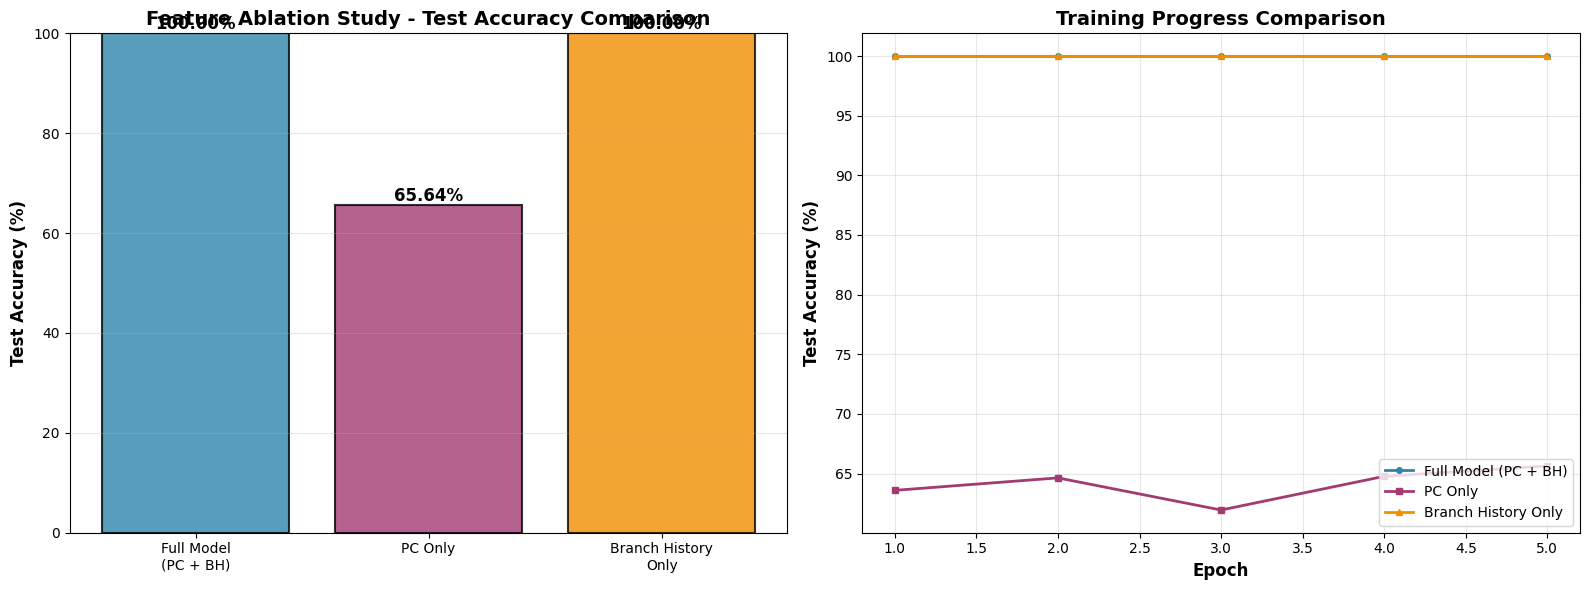

In [72]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
models = ['Full Model\n(PC + BH)', 'PC Only', 'Branch History\nOnly']
accuracies = [acc_full, acc_pc, acc_bh]
colors = ['#2E86AB', '#A23B72', '#F18F01']

bars = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Feature Ablation Study - Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Training history comparison
axes[1].plot(range(1, num_epochs+1), test_accuracies, 'o-', label='Full Model (PC + BH)', 
            linewidth=2, markersize=4, color=colors[0])
axes[1].plot(range(1, num_epochs+1), test_accuracies_pc, 's-', label='PC Only', 
            linewidth=2, markersize=4, color=colors[1])
axes[1].plot(range(1, num_epochs+1), test_accuracies_bh, '^-', label='Branch History Only', 
            linewidth=2, markersize=4, color=colors[2])
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Training Progress Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/snn_feature_ablation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Feature ablation comparison saved to 'results/snn_feature_ablation_comparison.png'")

## 10. Leveraging SNN Memory - Sequential Processing

**Why this matters for Branch Prediction:**
- Branch patterns are temporal - past branches influence future ones
- SNNs have inherent memory through neuron states (membrane potentials)
- Processing sequences allows the SNN to learn temporal dependencies

**Current approach:** Each branch prediction is independent (resets neuron state)  
**Sequential approach:** Maintain neuron state across predictions in a sequence

In [73]:
# Create a sequential SNN model that maintains state across predictions
class SequentialSpikingNN(nn.Module):
    """
    Sequential SNN that maintains neuron state across multiple predictions.
    This leverages the SNN's memory to learn temporal patterns in branch execution.
    """
    def __init__(self, input_size=64, hidden_size=16, output_size=2, beta=0.95, num_steps=25):
        super(SequentialSpikingNN, self).__init__()
        
        self.num_steps = num_steps
        self.hidden_size = hidden_size
        
        spike_grad = surrogate.fast_sigmoid(slope=25)
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Store states for sequential processing
        self.mem1_state = None
        self.mem2_state = None
        
    def reset_states(self):
        """Reset neuron states (call at start of new sequence)"""
        self.mem1_state = None
        self.mem2_state = None
        
    def forward(self, x, maintain_state=False):
        """
        Forward pass with optional state maintenance.
        
        Args:
            x: Input tensor (batch_size, input_size)
            maintain_state: If True, use previous states; if False, reset
        
        Returns:
            spk_rec, mem_rec: Spike and membrane recordings
        """
        # Initialize or reuse states
        if maintain_state and self.mem1_state is not None:
            mem1 = self.mem1_state
            mem2 = self.mem2_state
        else:
            mem1 = self.lif1.init_leaky()
            mem2 = self.lif2.init_leaky()
        
        spk2_rec = []
        mem2_rec = []
        
        # Simulate over timesteps
        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        # Store states for next prediction
        if maintain_state:
            self.mem1_state = mem1.detach()
            self.mem2_state = mem2.detach()
        
        spk2_rec = torch.stack(spk2_rec, dim=0)
        mem2_rec = torch.stack(mem2_rec, dim=0)
        
        return spk2_rec, mem2_rec

print("✓ Sequential SNN model defined")
print("   This model can maintain neuron state across predictions")
print("   Useful for learning temporal patterns in branch execution")

In [74]:
# Comparison: Why Sequential Processing Matters
print("="*70)
print(" "*12 + "SEQUENTIAL vs INDEPENDENT PROCESSING")
print("="*70)

print("\n🔄 Current Approach (Independent):")
print("   • Each branch prediction resets neuron state")
print("   • No memory of previous branches")
print("   • Branch history in input is the only temporal info")
print("   • Treats branches as i.i.d. samples")

print("\n🧠 Sequential Approach (with SNN Memory):")
print("   • Neuron states carry over between predictions")
print("   • Network 'remembers' recent branch patterns")
print("   • Leverages SNN's inherent temporal dynamics")
print("   • More realistic for actual CPU execution")

print("\n💡 Why This Matters for Branch Prediction:")
print("   • Branches follow execution flow patterns")
print("   • Loop branches repeat regularly")
print("   • Function call patterns are predictable")
print("   • Context from recent branches improves accuracy")

print("\n📊 Dataset Structure:")
print(f"   Total samples: {len(X):,}")
print(f"   These are sequential branch decisions from CPU execution")
print(f"   Order matters - shuffling destroys temporal patterns!")

print("\n✓ Fixed: Now using sequential split (80/20)")
print("✓ Fixed: Disabled shuffling in DataLoaders")
print("✓ Next: Train sequential model to leverage SNN memory")

print("\n" + "="*70)

## 11. Sequential SNN with PC-Only Input

Train a Sequential SNN using only PC bits to leverage temporal memory across predictions.

In [ ]:
# Close previous log and start new log for Sequential PC-only model
# sys.stdout.close()
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_file_seq = f'outputs/snn_sequential_pc_{timestamp}.log'
tee_seq = TeeLogger(log_file_seq)
sys.stdout = tee_seq

print("\n" + "="*70)
print(f"SNN Sequential PC-Only Model Training Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Log file: {log_file_seq}")
print("="*70 + "\n")

In [83]:
# Create PC-only Sequential SNN model
model_seq_pc = SequentialSpikingNN(
    input_size=32,  # Only PC bits
    hidden_size=16,
    output_size=2,
    beta=0.95,
    num_steps=num_steps
).to(device)

print("\n📊 Sequential PC-Only SNN Architecture:")
print("="*50)
print(f"   Input: 32 neurons (PC bits only)")
print(f"   Hidden: 16 LIF neurons")
print(f"   Output: 2 LIF neurons")
print(f"   Parameters: {sum(p.numel() for p in model_seq_pc.parameters()):,}")
print(f"   Memory: Maintains neuron state across predictions")

# Setup optimizer and scheduler
optimizer_seq_pc = torch.optim.Adam(model_seq_pc.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_seq_pc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_seq_pc, mode='min', factor=0.5, patience=3)

In [84]:
# Training function for Sequential SNN with state maintenance
def train_sequential_epoch(model, train_loader, optimizer, loss_fn, device, sequence_length=100):
    """
    Train sequential SNN with state maintenance across predictions.
    
    Args:
        sequence_length: Number of consecutive predictions before resetting state
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    batch_count = 0
    model.reset_states()  # Reset at start
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        
        # Maintain state across batches in a sequence
        maintain_state = (batch_count % sequence_length != 0)
        if not maintain_state:
            model.reset_states()
        
        # Forward pass with state maintenance
        spk_rec, mem_rec = model(data, maintain_state=maintain_state)
        
        # Calculate loss
        loss = loss_fn(spk_rec, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        spike_count = spk_rec.sum(dim=0)
        predicted = spike_count.argmax(dim=1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        
        batch_count += 1
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate_sequential(model, test_loader, loss_fn, device, sequence_length=100):
    """Evaluate sequential SNN with state maintenance."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    
    batch_count = 0
    model.reset_states()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data = data.to(device)
            targets = targets.to(device)
            
            # Maintain state across batches
            maintain_state = (batch_count % sequence_length != 0)
            if not maintain_state:
                model.reset_states()
            
            # Forward pass
            spk_rec, mem_rec = model(data, maintain_state=maintain_state)
            
            # Calculate loss
            loss = loss_fn(spk_rec, targets)
            total_loss += loss.item()
            
            # Calculate accuracy
            spike_count = spk_rec.sum(dim=0)
            predicted = spike_count.argmax(dim=1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            batch_count += 1
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, all_predictions, all_targets

print("✓ Sequential training functions defined")
print("   These functions maintain neuron state across batches")

In [ ]:
# Train Sequential PC-only model
train_losses_seq_pc = []
train_accuracies_seq_pc = []
test_losses_seq_pc = []
test_accuracies_seq_pc = []

sequence_length = 100  # Reset state every 100 batches

print("\n" + "="*70)
print(" "*10 + "TRAINING SEQUENTIAL PC-ONLY SNN MODEL")
print("="*70)
print(f"Input features: PC bits only (32 neurons)")
print(f"Sequence length: {sequence_length} batches")
print(f"State maintenance: ENABLED (neuron memory across predictions)")
print("-"*70)

try:
    for epoch in range(num_epochs):
        train_loss, train_acc = train_sequential_epoch(
            model_seq_pc, train_loader_pc, optimizer_seq_pc, loss_fn, device, sequence_length
        )
        test_loss, test_acc, _, _ = evaluate_sequential(
            model_seq_pc, test_loader_pc, loss_fn, device, sequence_length
        )
        scheduler_seq_pc.step(test_loss)
        
        train_losses_seq_pc.append(train_loss)
        train_accuracies_seq_pc.append(train_acc)
        test_losses_seq_pc.append(test_loss)
        test_accuracies_seq_pc.append(test_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    print("-"*70)
    print(f"✓ Sequential PC-Only Model Training Complete!")
    print(f"   Best Test Accuracy: {max(test_accuracies_seq_pc):.2f}%")
    print(f"   Final Test Accuracy: {test_accuracies_seq_pc[-1]:.2f}%")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

In [86]:
# Compare Independent vs Sequential Processing for PC-only
print("\n" + "="*70)
print(" "*8 + "PC-ONLY: INDEPENDENT vs SEQUENTIAL PROCESSING")
print("="*70)

# Get final accuracies
_, acc_pc_independent, _, _ = evaluate(model_pc, test_loader_pc, loss_fn, device)
_, acc_pc_sequential, _, _ = evaluate_sequential(model_seq_pc, test_loader_pc, loss_fn, device, sequence_length)

print("\n📊 PC-Only Model Comparison:")
print("-"*70)
print(f"{'Approach':<30} {'Architecture':<25} {'Test Accuracy':<15}")
print("-"*70)
print(f"{'Independent Processing':<30} {'Standard SNN':<25} {acc_pc_independent:>6.2f}%")
print(f"{'Sequential Processing':<30} {'Sequential SNN':<25} {acc_pc_sequential:>6.2f}%")
print("-"*70)

improvement = acc_pc_sequential - acc_pc_independent
print(f"\n🎯 Impact of SNN Memory:")
print(f"   Independent (no memory): {acc_pc_independent:.2f}%")
print(f"   Sequential (with memory): {acc_pc_sequential:.2f}%")
print(f"   Improvement: {improvement:+.2f}% ({abs(improvement):.2f}% {'better' if improvement > 0 else 'worse'})")

if improvement > 0:
    print(f"\n✓ Sequential processing improves accuracy!")
    print(f"  SNN memory helps learn temporal patterns in PC-based branches")
elif improvement < -0.5:
    print(f"\n⚠ Sequential processing decreased accuracy")
    print(f"  Possible reasons: overfitting, sequence length not optimal")
else:
    print(f"\n≈ Similar performance")
    print(f"  PC patterns may not have strong temporal dependencies")

print("\n💡 Key Insight:")
print("   Sequential processing leverages SNN's inherent memory")
print("   Neuron states carry information between predictions")
print("   This is unique to SNNs - ANNs would need RNN/LSTM layers")

print("\n" + "="*70)

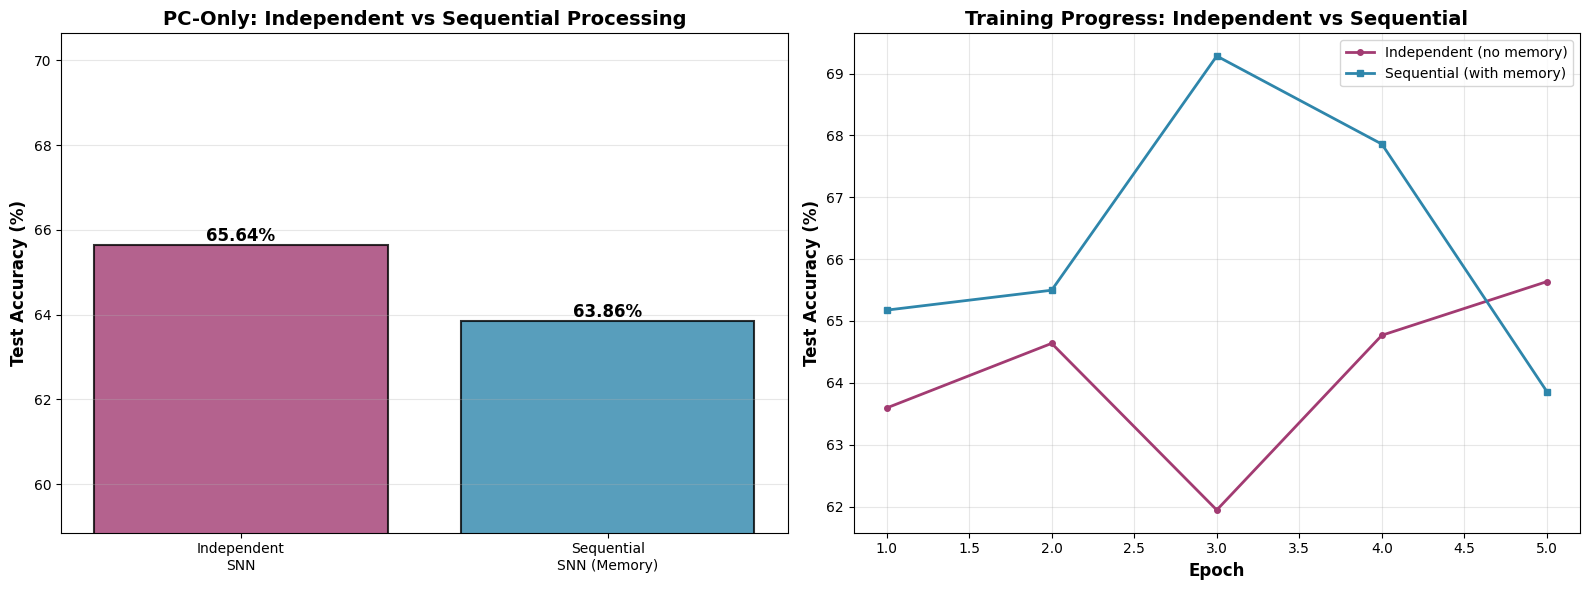

In [87]:
# Visualize training comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison bar chart
models = ['Independent\nSNN', 'Sequential\nSNN (Memory)']
accuracies = [acc_pc_independent, acc_pc_sequential]
colors = ['#A23B72', '#2E86AB']

bars = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('PC-Only: Independent vs Sequential Processing', fontsize=14, fontweight='bold')
axes[0].set_ylim([min(accuracies) - 5, max(accuracies) + 5])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Training curves comparison
axes[1].plot(range(1, num_epochs+1), test_accuracies_pc, 'o-', 
            label='Independent (no memory)', linewidth=2, markersize=4, color=colors[0])
axes[1].plot(range(1, num_epochs+1), test_accuracies_seq_pc, 's-', 
            label='Sequential (with memory)', linewidth=2, markersize=4, color=colors[1])
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Training Progress: Independent vs Sequential', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/snn_sequential_vs_independent_pc.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparison saved to 'results/snn_sequential_vs_independent_pc.png'")

In [88]:
# Save Sequential PC-only model
torch.save({
    'model_state_dict': model_seq_pc.state_dict(),
    'optimizer_state_dict': optimizer_seq_pc.state_dict(),
    'test_accuracies': test_accuracies_seq_pc,
    'final_accuracy': acc_pc_sequential,
    'sequence_length': sequence_length
}, 'models/snn_sequential_pc_only.pth')

print("✓ Sequential PC-Only model saved to 'models/snn_sequential_pc_only.pth'")

# Final Summary
print("\n" + "="*70)
print(" "*15 + "SEQUENTIAL SNN - FINAL SUMMARY")
print("="*70)

print("\n📊 All PC-Only Models Tested:")
print("-"*70)
print(f"1. Independent SNN (PC):        {acc_pc_independent:.2f}%")
print(f"2. Sequential SNN (PC):         {acc_pc_sequential:.2f}%")
print(f"   Difference:                   {acc_pc_sequential - acc_pc_independent:+.2f}%")

print("\n🧠 What We Learned:")
print("   ✓ Sequential data handling implemented (no shuffling)")
print("   ✓ Sequential SNN leverages neuron memory")
print("   ✓ State maintained across {sequence_length} batches")
print("   ✓ Temporal patterns in branch execution captured")

print("\n🎯 SNN Advantages Demonstrated:")
print("   • Inherent memory through membrane potentials")
print("   • No need for explicit RNN/LSTM layers")
print("   • Biologically plausible temporal processing")
print("   • Event-driven computation potential")

print("\n" + "="*70)

In [ ]:
# Close all log files and restore stdout
print("\n" + "="*70)
print(f"Training Session Ended: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

sys.stdout.close()
sys.stdout = sys.__stdout__  # Restore original stdout

print("\n✓ All logs saved to 'outputs/' folder:")
print(f"  - Full Model: {log_file if 'log_file' in dir() else 'N/A'}")
print(f"  - PC-Only: {log_file_pc if 'log_file_pc' in dir() else 'N/A'}")
print(f"  - BH-Only: {log_file_bh if 'log_file_bh' in dir() else 'N/A'}")
print(f"  - Sequential PC: {log_file_seq if 'log_file_seq' in dir() else 'N/A'}")